One of the biggest challenges I face maintaining large Postgres systems is getting data *into* them in an efficient manner. Postgres is very, very good at maintaining, organising, querying and retrieving data, but inserts themselves can be quite slow.

Various stackoverflow questions suggest using things like `COPY`, but that assumes your application has direct write access to the machine that is running Postgres, and I work very hard to maintain strict seperation of functionality between software components.

So I've been looking for a faster way of inserting, say, 100,000 rows into the database across the wire, and what follows is by far the most efficient technique I've found so far.

### Set some visualisation options

In [1]:
%matplotlib inline
import seaborn

### Import the libraries we'll be using

In [4]:
import pandas
from numpy import array_split
import psycopg2
from psycopg2.extras import Json
import time
import contextlib

### A context manager for timing operations.

In [5]:
@contextlib.contextmanager
def timer(name="duration"):
    'Utility function for timing execution'
    start=time.time()
    yield
    duration=time.time()-start
    print("{0}: {1} second(s)".format(name,duration))

### Test setup

My tests are based on creating a fairly simple table and timing how long it takes to perform inserts on it via several different methods.
The table has a couple of default columns, a text column, and an HSTORE column.

In [ ]:

SETUP_SQL="""
    DROP TABLE IF EXISTS upload_time_test;
    
    CREATE TABLE upload_time_test(
        uuid uuid primary key default uuid_generate_v4(),
        created timestamp with time zone not null default now(),
        text text not null,
        properties hstore not null default ''::hstore
    );
    
    GRANT ALL ON upload_time_test TO test;
"""


This is the SQL we'll use for inserting a single row into the database table:

In [8]:

SINGLE_INSERT="""
    INSERT INTO upload_time_test(text,properties)
         VALUES (%(text)s, %(properties)s)
"""

Credentials for connecting to my local test database

In [9]:
HOST='localhost'
DATABASE='test'
USER='test'
PASSWORD='password'

Then we define a couple of simple wrappers around `psycopg2` 

In [10]:
def connect():
    connection= psycopg2.connect(host=HOST,database=DATABASE,user=USER,password=PASSWORD)
    psycopg2.extras.register_hstore(connection)
    return connection
def execute(sql,params={}):
    with connect() as connection:
        with connection.cursor() as cursor:
            cursor.execute(sql,params)

This is the heart of my tests.  The `Tester` class destroys and re-creates the sample table every time we instantiate it.

It provides three different functions for inserting database rows, each based on a different technique.

 * `slowInsert()` is the slowest, because it creates a new database connection for each row
 * `insert()` is the approach I had been using up till now. It creates one connection, and re-uses it for each insertion. This is basically what `executemany()` in psycopg2 is doing.
 * `fastInsert()` is my new approach, based on using **unnest()** to unroll a set of arrays passed in through psycopg2

In [11]:
class Tester():   
    def __init__(self,count):
        execute(SETUP_SQL)
        self.count=count
        
        self.data=[
            {
                'text':'Some text',
                'properties': {"key":"value"},
            }
            for i in range(count)
        ]

    def slowInsert(self):
        '''
            Creates a new connection for each insertion
        '''
        for row in self.data:
            text=row['text']
            properties=row['properties']
            execute(SINGLE_INSERT,locals())
        
    def insert(self):
        '''
            One connection.
            Multiple queries.
        '''
        with connect() as connection:
            with connection.cursor() as cursor:
                for row in self.data:
                    text=row['text']
                    properties=row['properties']
                    cursor.execute(SINGLE_INSERT,locals())
                    
        
    def fastInsert(self):
        ''' 
            One connection, one query.
        '''
        sql='''
            INSERT INTO upload_time_test(text,properties)
              SELECT unnest( %(texts)s ) ,
                     unnest( %(properties)s) 

        '''
        
        texts=[r['text'] for r in self.data]
        properties=[r['properties'] for r in self.data]
        execute(sql,locals())
   

So now we have the Tester class written, we can see how log each approach takes to insert 1000 rows

In [12]:
def runTests(iterations):
    tester = Tester(iterations)
    with timer('slow'):
        tester.slowInsert()
    with timer('normal'):
        tester.insert()
    with timer('fast'):
        tester.fastInsert()


In [13]:
runTests(1000)

slow: 7.160489320755005 second(s)
normal: 0.1441025733947754 second(s)
fast: 0.042119503021240234 second(s)


**We notice an obvious difference between the approaches.**

Re-using the connection makes a *huge* difference. Inserts run 50 times faster.

Using `unnest()` runs 3 times faster than that.

## What about much bigger data sets?

Next, I wanted to know if this held true for inserting, say, 100,000 rows.  I won't bother with the slowest approach, because that's clearly unusable.

In [14]:
tester=Tester(count=100000)
with timer('normal'):
    tester.insert()
    
tester=Tester(count=100000)
with timer('fast'):
    tester.fastInsert()


normal: 14.866096019744873 second(s)
fast: 3.9566986560821533 second(s)


So even over 100,000 rows we still run nearly 4 times faster using `unnest`

## Further investigation - mapping insertion rate against number of rows inserted.

I wanted to see the exact relationship between the rate of insertion and the number of rows being inserted.

So first I wrote a couple of functions to measure the insertion rate of our two methods:

In [15]:

def bulkInsertRate(count):
    tester=Tester(count)
    start=time.time()
    tester.fastInsert()
    duration=time.time()-start
    return count/duration

def normalInsertRate(count):
    tester=Tester(count)
    start=time.time()
    tester.insert()
    duration=time.time()-start
    return count/duration


And then we run them with a range of dataset sizes

In [17]:
counts=[50,100,200,500,1000,2000,5000,10000,20000,50000,100000]

rates=[
    {
        "count":count,
         'bulk':bulkInsertRate(count),
        'normal':normalInsertRate(count)
            
    }
    for count in counts
]


Finally, I use Pandas to plot the output data from these tests.

In [18]:
frame=pandas.DataFrame(rates).set_index('count')
frame

,bulk,normal
count,,
50,4485.694730,3867.856879
100,10159.389609,4847.897547
200,15212.186276,6057.106548
500,27340.842720,7081.049689
1000,33248.545382,7694.657609
2000,35640.695767,7070.777670
5000,41223.200473,8027.790910
10000,40948.723106,7785.005392
20000,42604.387914,7568.314015


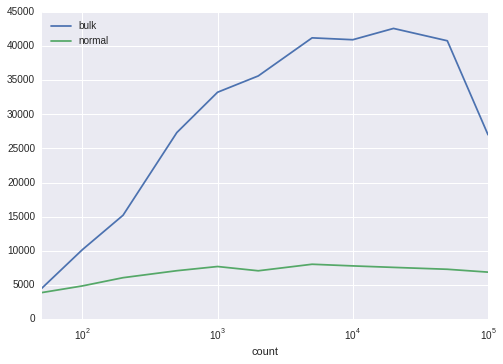

In [19]:
frame.plot(logx=True)

## Conclusion

Using `unnest` to load multiple rows simultaneously has the following advantages:

* It is significantly faster than a regular insert loop, especially when inserting thousands of rows.
* The benefits of using unnest() increase at least up to 50,000 rows
* It still allows us to write (reasonably) straightforward parameterised SQL with no string concatenation
* When I tried this on a remote database, the improvements were even more impressive, presumably as it reduces significantly how much data is transferred back and forth across the network.